<a href="https://colab.research.google.com/github/atick-faisal/TAVI/blob/main/src/colab/MultiViewPix2Pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab Info

In [ ]:
from psutil import virtual_memory

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)


ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('Not using a high-RAM runtime')
else:
    print('You are using a high-RAM runtime!')


Sun Mar 19 09:55:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Download Dataset

In [ ]:
!pip install -U --no-cache-dir gdown --pre > /dev/null


In [ ]:
!gdown "1fxpztPak4HFNq-YSyYY-6qjC61xYMM9u"
!unzip -o "GEOMETRY_2_ECAP_ALT.zip" > /dev/null


Downloading...
From: https://drive.google.com/uc?id=13uGBcIYhZqyEhy1CM4XFPDXbq4T_pL-S
To: /content/GEOMETRY_2_ECAP.zip
100% 882M/882M [00:04<00:00, 203MB/s]


# Imports

In [ ]:
import os
import cv2
import time
import random
import datetime
import matplotlib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython import display
from numpy.typing import NDArray

# matplotlib.use('Agg')
plt.rcParams["font.size"] = 16


# Config

In [ ]:
DATASET = "GEOMETRY_2_ECAP_ALT"
MODEL_NAME = "MultiViewPix2Pix"
DATASET_PATH = "/content/Images/"
TRAIN_DIR = "Train/"
TEST_DIR = "Test/"
INPUT_DIR = "Input/"
TARGET_DIR = "Target/"
MODEL_PATH = "/content/drive/MyDrive/Research/TAVI/Models/"
PRED_PATH = "/content/drive/MyDrive/Research/TAVI/Predictions/"

IMG_SIZE = 256
BATCH_SIZE = 16
BUFFER_SIZE = 1000
VAL_SPLIT = 0.2
LEARNING_RATE = 3e-4
STEPS = 7000

LAMBDA = 100


EXP_NAME = f"{MODEL_NAME}_I{IMG_SIZE}_B{BATCH_SIZE}_LR{LEARNING_RATE}_LM{LAMBDA}_{DATASET}"
CHECKPOINT_PATH = os.path.join(MODEL_PATH, EXP_NAME)


# Architecture

## Generator

In [ ]:
class Generator:
    def __init__(
        self,
        img_size: int,
        n_channels: int
    ):
        self.img_size = img_size
        self.n_channels = n_channels

    @staticmethod
    def downsample(
        filters: int,
        kernel_size: int,
        apply_batchnorm: bool = True
    ):
        initializer = tf.random_normal_initializer(0., 0.02)
        result = tf.keras.Sequential()
        result.add(
            tf.keras.layers.Conv2D(
                filters=filters,
                kernel_size=kernel_size,
                strides=2,
                padding="same",
                kernel_initializer=initializer,
                use_bias=False
            )
        )

        if apply_batchnorm:
            result.add(tf.keras.layers.BatchNormalization())

        result.add(tf.keras.layers.LeakyReLU())

        return result

    @staticmethod
    def upsample(
        filters: int,
        kernel_size: int,
        apply_dropout: bool = False
    ):
        initializer = tf.random_normal_initializer(0., 0.02)

        result = tf.keras.Sequential()
        result.add(
            tf.keras.layers.Conv2DTranspose(
                filters=filters,
                kernel_size=kernel_size,
                strides=2,
                padding="same",
                kernel_initializer=initializer,
                use_bias=False
            )
        )

        result.add(tf.keras.layers.BatchNormalization())

        if apply_dropout:
            result.add(tf.keras.layers.Dropout(0.5))

        result.add(tf.keras.layers.ReLU())

        return result

    def __call__(self):
        inputs = tf.keras.layers.Input(
            shape=(self.img_size, self.img_size, self.n_channels)
        )

        down_stack = [
            # (batch_size, 128, 128, 64)
            self.downsample(64, 4, apply_batchnorm=False),
            self.downsample(128, 4),  # (batch_size, 64, 64, 128)
            self.downsample(256, 4),  # (batch_size, 32, 32, 256)
            self.downsample(512, 4),  # (batch_size, 16, 16, 512)
            self.downsample(512, 4),  # (batch_size, 8, 8, 512)
            self.downsample(512, 4),  # (batch_size, 4, 4, 512)
            self.downsample(512, 4),  # (batch_size, 2, 2, 512)
            self.downsample(512, 4),  # (batch_size, 1, 1, 512)
        ]

        up_stack = [
            # (batch_size, 2, 2, 1024)
            self.upsample(512, 4, apply_dropout=True),
            # (batch_size, 4, 4, 1024)
            self.upsample(512, 4, apply_dropout=True),
            # (batch_size, 8, 8, 1024)
            self.upsample(512, 4, apply_dropout=True),
            self.upsample(512, 4),  # (batch_size, 16, 16, 1024)
            self.upsample(256, 4),  # (batch_size, 32, 32, 512)
            self.upsample(128, 4),  # (batch_size, 64, 64, 256)
            self.upsample(64, 4),  # (batch_size, 128, 128, 128)
        ]

        initializer = tf.random_normal_initializer(0., 0.02)
        last = tf.keras.layers.Conv2DTranspose(
            filters=self.n_channels,
            kernel_size=4,
            strides=2,
            padding="same",
            kernel_initializer=initializer,
            activation="tanh"
        )  # (batch_size, 256, 256, 3)

        x = inputs

        # Downsampling through the model
        skips = []
        for down in down_stack:
            x = down(x)
            skips.append(x)

        skips = reversed(skips[:-1])

        # Upsampling and establishing the skip connections
        for up, skip in zip(up_stack, skips):
            x = up(x)
            x = tf.keras.layers.Concatenate()([x, skip])

        x = last(x)

        return tf.keras.Model(inputs=inputs, outputs=x)


In [ ]:
# generator = Generator(IMG_SIZE, 3)()
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

## Discriminator

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    # (batch_size, 256, 256, channels*2)
    x = tf.keras.layers.concatenate([inp, tar])

    down1 = Generator.downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = Generator.downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = Generator.downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(
        leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


# Loss Functions

In [ ]:
def attention_mse(y_true, y_pred):
    _y_true = y_true[y_true != -1.0]
    _y_pred = y_pred[y_true != -1.0]
    squared_difference = tf.square(_y_true - _y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)


def attention_mae(y_true, y_pred):
    _y_true = y_true[y_true != -1.0]
    _y_pred = y_pred[y_true != -1.0]
    squared_difference = tf.abs(_y_true - _y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)


loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(
        disc_generated_output), disc_generated_output)

    # Mean absolute error
    # l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    l1_loss = attention_mae(target, gen_output)

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss


def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(
        disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss





In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=0.5)



In [ ]:
generator = Generator(IMG_SIZE, 3)()
discriminator = Discriminator()

checkpoint_prefix = os.path.join(CHECKPOINT_PATH, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)


In [ ]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()


In [ ]:
log_dir = "logs/"

summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


In [ ]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator(
            [input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                 discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)


In [ ]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            # display.clear_output(wait=True)

            if step != 0:
                print(
                    f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

            start = time.time()

            generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")

        train_step(input_image, target, step)

        # Training step
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)

        # Save (checkpoint) the model every 5k steps
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)


In [ ]:
%load_ext tensorboard
%tensorboard serve -logdir {log_dir}


ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2023-03-19 09:56:10.214716: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-03-19 09:56:10.214872: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-03-19 09:56:10.214893: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are inst

# Utils

In [ ]:
def load_data_from_dir(path: str) -> tf.data.Dataset:
    return tf.keras.utils.image_dataset_from_directory(
        directory=path,
        labels=None,
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        image_size=(IMG_SIZE, IMG_SIZE),
        shuffle=True,
        seed=42,
        # validation_split=VAL_SPLIT,
        # subset=subset,
        interpolation='bilinear',
        follow_links=False,
        crop_to_aspect_ratio=False
    )


# Dataloaders

In [ ]:
trainX = load_data_from_dir(os.path.join(DATASET_PATH, TRAIN_DIR, INPUT_DIR))
trainY = load_data_from_dir(os.path.join(DATASET_PATH, TRAIN_DIR, TARGET_DIR))
testX = load_data_from_dir(os.path.join(DATASET_PATH, TEST_DIR, INPUT_DIR))
testY = load_data_from_dir(os.path.join(DATASET_PATH, TEST_DIR, TARGET_DIR))

train_ds = tf.data.Dataset.zip((trainX, trainY))
test_ds = tf.data.Dataset.zip((testX, testY))

print(train_ds.element_spec)
print(test_ds.element_spec)


Found 7308 files belonging to 1 classes.
Found 7308 files belonging to 1 classes.
Found 612 files belonging to 1 classes.
Found 612 files belonging to 1 classes.
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))


# Normalization

In [ ]:
# def normalize(input_image, output_image):
#     input_image = tf.cast(input_image, tf.float32) / 255.0
#     output_image = tf.cast(input_image, tf.float32) / 255.0
#     return input_image, output_image


In [ ]:
# normalization_layer = tf.keras.layers.Rescaling(1./255)
# train_ds = train_ds.map(lambda x, y: (
#     normalization_layer(x), normalization_layer(y)))
# test_ds = test_ds.map(lambda x, y: (
#     normalization_layer(x), normalization_layer(y)))


In [ ]:
train_ds = train_ds.map(lambda x, y: (
    (x / 127.5) - 1.0, (y / 127.5) - 1.0))
test_ds = test_ds.map(lambda x, y: (
        (x / 127.5) - 1.0, (y / 127.5) - 1.0))


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


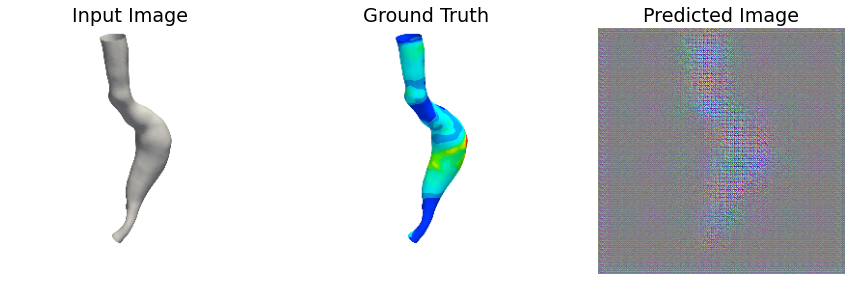

Step: 0k
....................................................................................................Time taken for 1000 steps: 608.54 sec



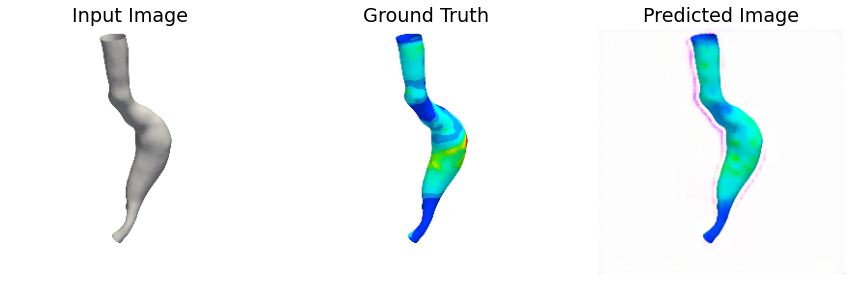

Step: 1k
....................................................................................................Time taken for 1000 steps: 590.08 sec



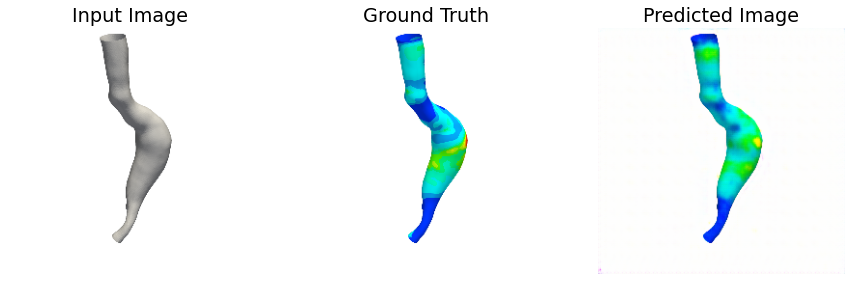

Step: 2k
....................................................................................................Time taken for 1000 steps: 590.52 sec



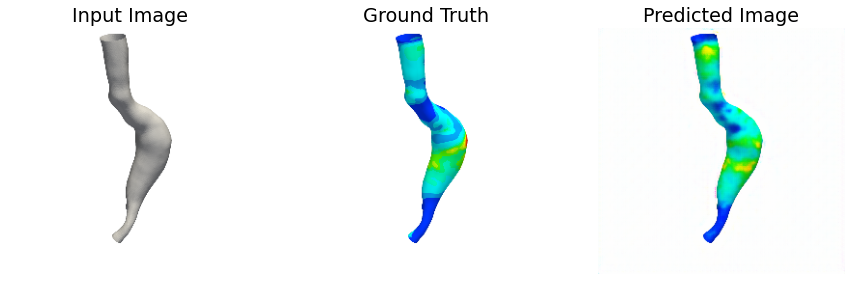

Step: 3k
...................................................................................................Time taken for 1000 steps: 591.19 sec



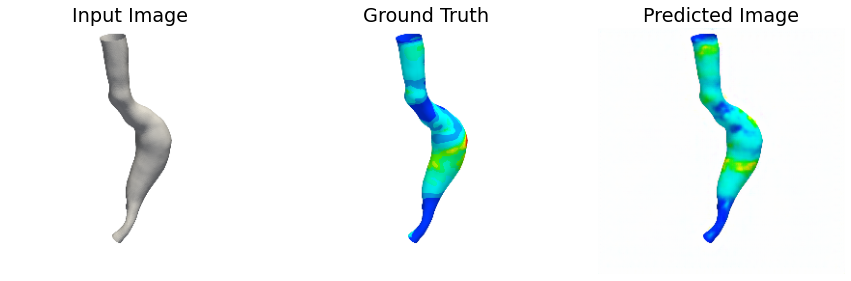

Step: 4k
....................................................................................................Time taken for 1000 steps: 594.50 sec



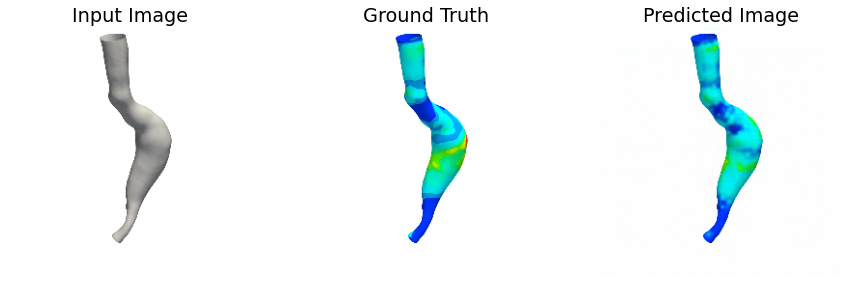

Step: 5k
....................................................................................................Time taken for 1000 steps: 589.80 sec



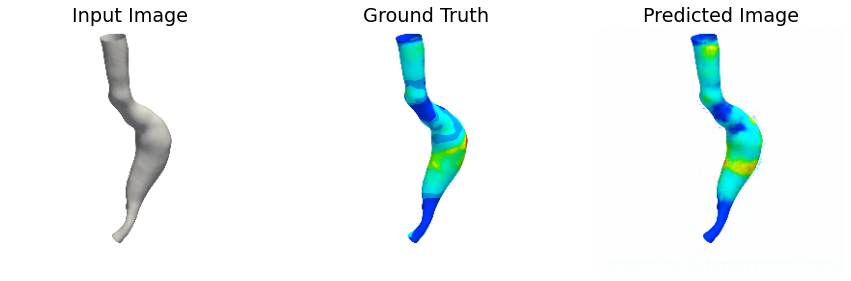

Step: 6k
....................................................................................................

In [ ]:
# train_ds = train_ds.shuffle(8208)
fit(train_ds, test_ds, steps=STEPS)


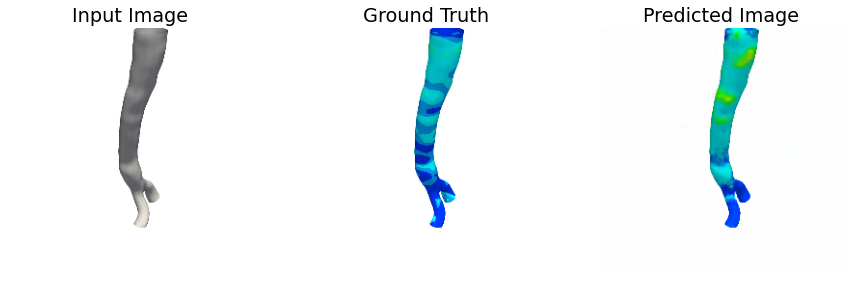

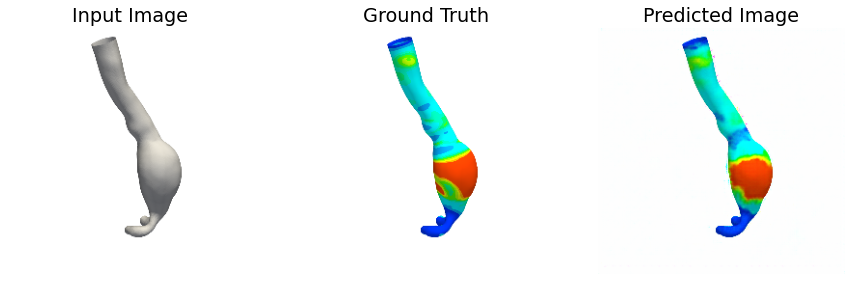

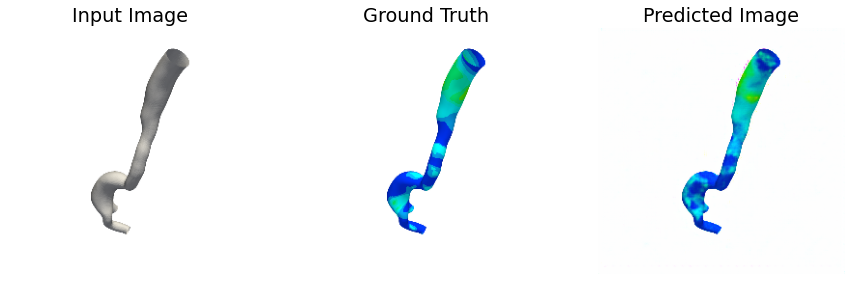

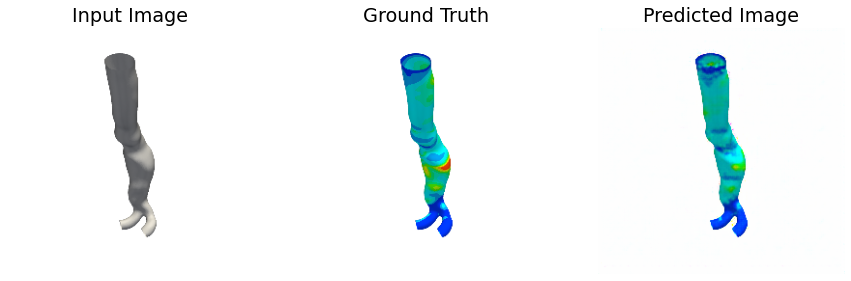

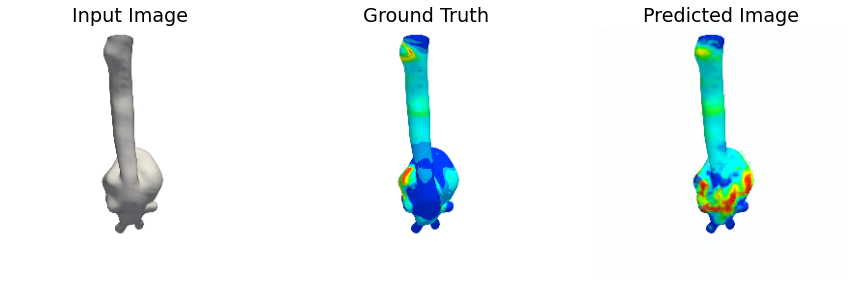

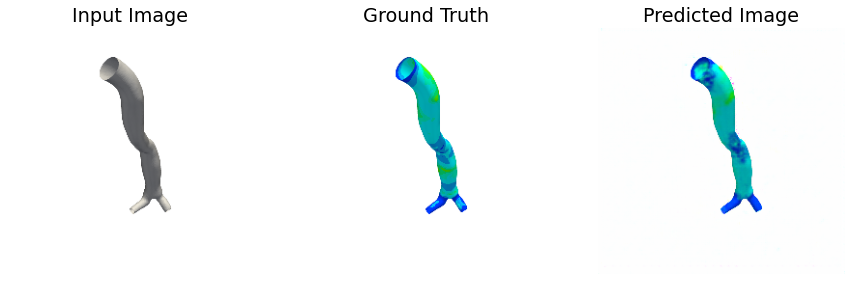

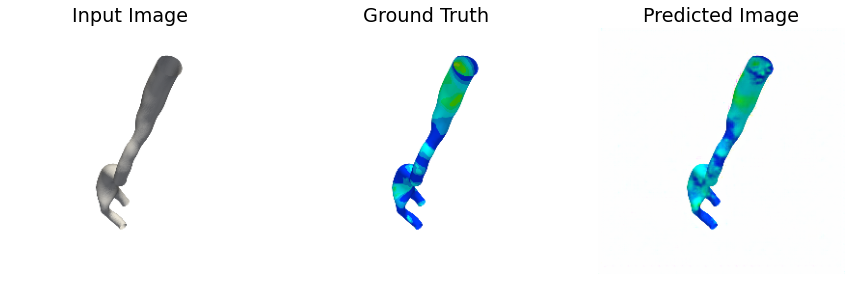

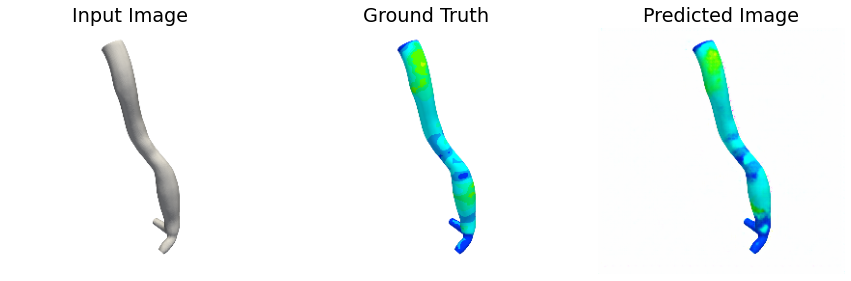

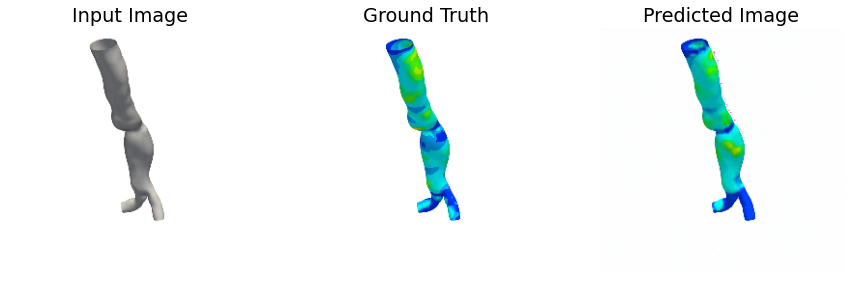

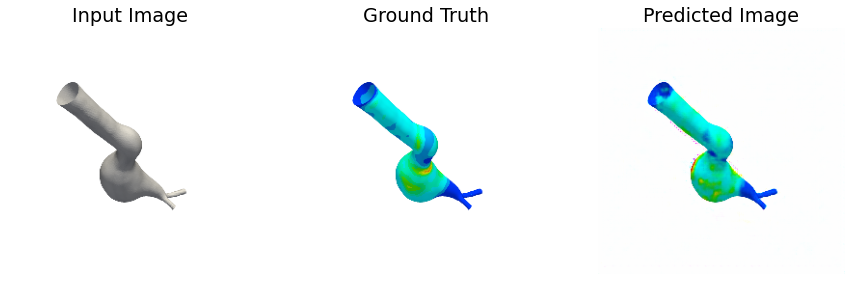

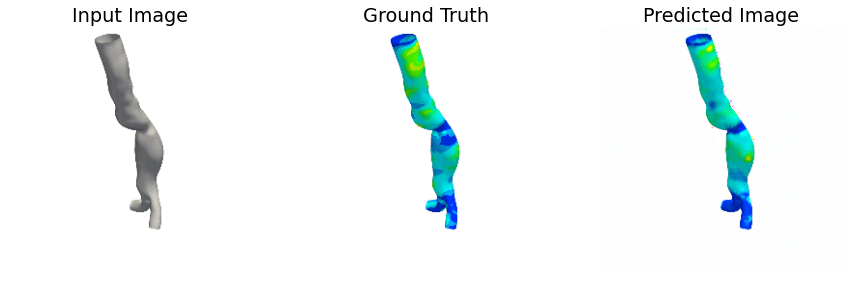

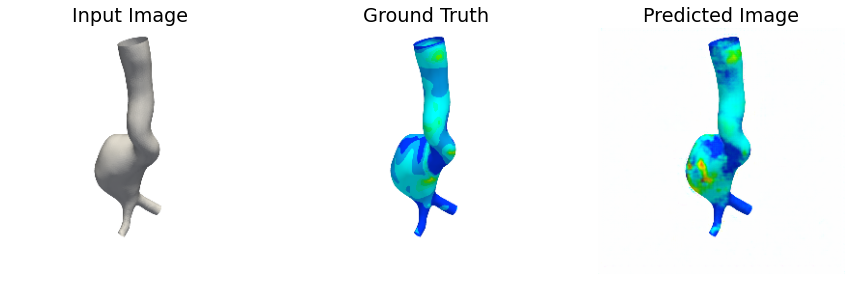

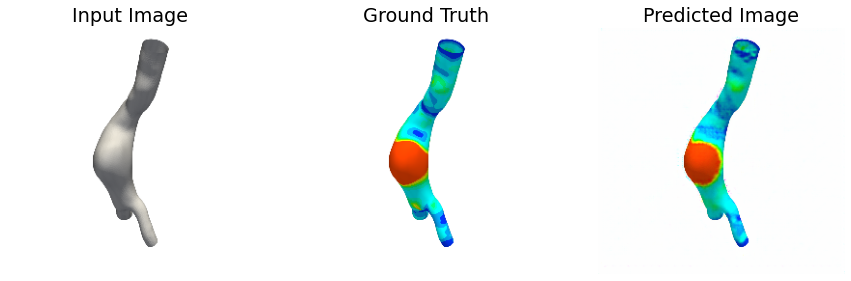

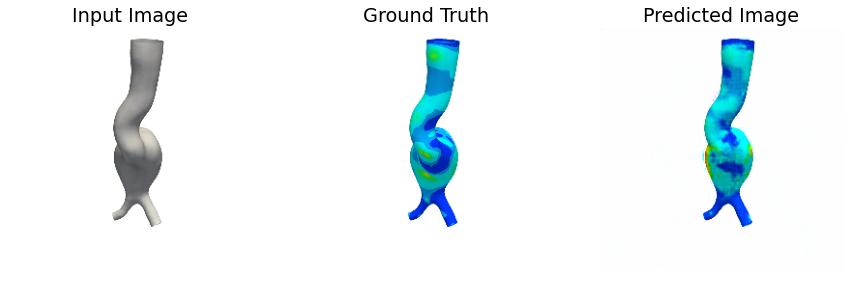

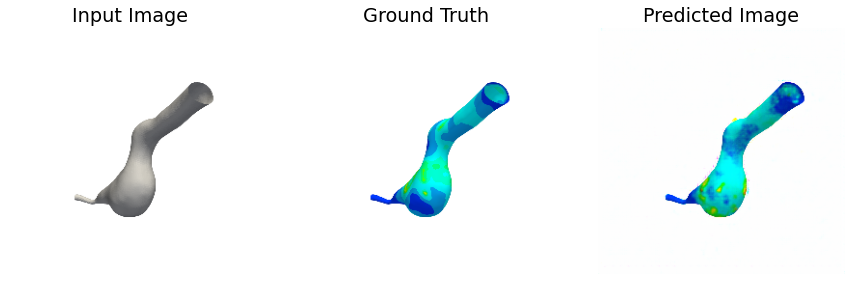

In [ ]:
for inp, tar in test_ds.take(15):
    generate_images(generator, inp, tar)


In [ ]:
timestamp = datetime.datetime.now().strftime('%b-%d-%I:%M%p')

test_ds_unbatched = test_ds.unbatch()

pred_path = os.path.join(PRED_PATH, EXP_NAME, timestamp)
if not os.path.exists(pred_path):
    os.makedirs(pred_path)

metrics = pd.DataFrame()

count = 0
mae = tf.Variable(0.0)
mse = tf.Variable(0.0)

for idx, (input, target) in enumerate(tqdm(test_ds_unbatched)):

    # if not idx % 10 == 0:
    #     continue

    
    # prediction = tf.squeeze(
    #     model.predict(
    #         tf.expand_dims(input, axis=0)
    #         )
    #     ).numpy()
    prediction = generator(tf.expand_dims(input, axis=0), training=True)

    mae = mae + attention_mae(tf.expand_dims(target, axis=0), prediction)
    mse = mse + attention_mse(tf.expand_dims(target, axis=0), prediction)
    count = count + 1

    prediction = tf.squeeze(prediction).numpy()
    target = tf.squeeze(target).numpy()
    
    prediction[target == -1.0] = -1.0

    # _metrics = pd.DataFrame([[
    #         rmse(target, prediction),
    #         psnr(target, prediction),
    #         ssim(target, prediction),
    #         fsim(target, prediction),
    #         issm(target, prediction),
    #         sre(target, prediction),
    #         sam(target, prediction),
    #         uiq(target, prediction),
    #     ]],
    #     columns=["RMSE", "PSNR", "SSIM", "FSIM", "ISSM", "SRE", "SAM", "UIQ"]
    # )

    # metrics = pd.concat([metrics, _metrics], axis=0)

    plt.figure(figsize=(7, 7))
    plt.imshow(target * 0.5 + 0.5)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(os.path.join(pred_path, f"{idx}_T.png"))
    plt.close()

    plt.figure(figsize=(7, 7))
    plt.imshow(prediction * 0.5 + 0.5)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(os.path.join(pred_path, f"{idx}_P.png"))
    plt.close()


    # plt.figure(figsize=(12, 4))
    # plt.subplot(1, 3, 1)
    # plt.imshow(input)
    # plt.axis("off")
    # plt.title("INPUT")
    # plt.subplot(1, 3, 2)
    # plt.imshow(target)
    # plt.axis("off")
    # plt.title("TARGET")
    # plt.subplot(1, 3, 3)
    # plt.imshow(prediction)
    # plt.axis("off")
    # plt.title("PREDICTION")
    # plt.tight_layout()
    # plt.savefig(os.path.join(pred_path, f"{idx}.png"))
    # plt.close() 

print(f"MAE = {mae/count}") 
print(f"MSE = {mse/count}") 


612it [03:30,  2.90it/s]

MAE = 0.22830723226070404
MSE = 0.20337116718292236
